## Проект: спрогнозировать количество отправок зерна в тоннах на следующий месяц

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### Датасеты у нас разбросаны, так что надо будет их сконкатинировать

In [2]:
df = pd.read_csv('2019 4.5.6.7.8.csv',sep=';',encoding='windows-1251')
df = df.append(pd.read_csv('2019 9.10.11.12.csv',sep=';',encoding='windows-1251'))
df = df.append(pd.read_csv('2020 1.2.3.4.csv',sep=';',encoding='windows-1251'))
df = df.append(pd.read_csv('2020 5.6.7.8.csv',sep=';',encoding='windows-1251'))
df = df.append(pd.read_csv('2020 9.10.11.12.csv',sep=';',encoding='windows-1251'))
df = df.append(pd.read_csv('2021 1.2.3.4.csv',sep=';',encoding='windows-1251'))
df = df.append(pd.read_csv('2021 5.6.7.8.csv',sep=';',encoding='windows-1251'))
df = df.append(pd.read_csv('2021 9.10.11.12.csv',sep=';',encoding='windows-1251'))
df = df.append(pd.read_csv('2022 1.2.3.4.csv',sep=';',encoding='windows-1251'))
df = df.append(pd.read_csv('2022 5.6.7.csv',sep=';',encoding='windows-1251'))
df.reset_index(drop=True, inplace=True)

In [3]:
df.head()

,Номер заявки,План дата,Вид сообщения,месяц,Год,Номенклатурная группа грузов,Код станции \nотправления,Наименование \nстанции отправления,Отправитель,Ветвевладелец,...,Наименование груза ЕТСНГ,Код груза ГНГ,Наименование груза ГНГ,Код станции \nназначения,Наименование \nстанции назначения,Страна назначения,Род вагона,Тип вагона,Количество \nвагонов,Количество \nтонн
0,187010,02.04.2019,"экспорт в страны СНГ, Латвийскую Республику, Л...",4,2019,ЛОМ ЧЕРНЫХ МЕТАЛЛОВ,684001,Костанай,"ТОО ""МЕТАЛЛ ЛИДЕР""","ТОО ""Уральское""",...,"Лом черных металлов,не поименованный в алфавите",72041000.0,Отходы и лом литейного чугуна,817600.0,Магнитогорск-Грузовой,РОССИЯ,ПОЛУВАГОНЫ,Полувагон 4-осный с люками в полу без тормозно...,6,360
1,187011,02.04.2019,"экспорт в страны СНГ, Латвийскую Республику, Л...",4,2019,ЗЕРНО,687008,Кокшетау I,ТОО ANKA GROUP (АНКА ГРУПП),"ТОО ""АСЫЛ АРМАН""",...,Чечевица,7134000.0,"Чечевица сушеная, лущеная, очищенная от семенн...",548004.0,Апшерон,АЗЕРБАЙДЖАН,КРЫТЫЕ,Крытый 4-осный с объемом кузова 120 куб.м и бо...,1,68
2,187011,09.04.2019,"экспорт в страны СНГ, Латвийскую Республику, Л...",4,2019,ЗЕРНО,687008,Кокшетау I,ТОО ANKA GROUP (АНКА ГРУПП),"ТОО ""АСЫЛ АРМАН""",...,Чечевица,7134000.0,"Чечевица сушеная, лущеная, очищенная от семенн...",548004.0,Апшерон,АЗЕРБАЙДЖАН,КРЫТЫЕ,Крытый 4-осный с объемом кузова 120 куб.м и бо...,1,68
3,187011,12.04.2019,"экспорт в страны СНГ, Латвийскую Республику, Л...",4,2019,ЗЕРНО,687008,Кокшетау I,ТОО ANKA GROUP (АНКА ГРУПП),"ТОО ""АСЫЛ АРМАН""",...,Чечевица,7134000.0,"Чечевица сушеная, лущеная, очищенная от семенн...",548004.0,Апшерон,АЗЕРБАЙДЖАН,КРЫТЫЕ,Крытый 4-осный с объемом кузова 120 куб.м и бо...,1,68
4,187012,01.04.2019,межобластное,4,2019,ЦЕМЕНТ,663503,Актау-Порт,"ТОО ""URYAT TRADING LTD""","АО ""КАСКОР-ТРАНССЕРВИС""",...,"Цемент,не поименованный в алфавите",25232100.0,"Портландцемент белый, искусственно окрашенный ...",700007.0,Алматы 1,КАЗАХСТАН,КРЫТЫЕ,Крытый 4-осный с объемом кузова менее 120 куб....,2,136


#### Берем зерно

In [3]:
data = df[df['Номенклатурная группа грузов'] == 'ЗЕРНО']

#### С групперируем код станции и выведем в общей сложности количество вагонов

In [4]:
pd.DataFrame(data.groupby(['Код станции \nотправления'])['Количество \nвагонов'].sum()).sort_values(by = ['Количество \nвагонов'], ascending=False)

,Количество \nвагонов
Код станции отправления,
685707,49578
691503,38564
691109,25124
684001,24607
696102,16786
...,...
660308,2
661809,1
695701,1


In [5]:
data = df[(df['Номенклатурная группа грузов'] == 'ЗЕРНО') & (df['Код станции \nотправления'] == 685707)]

In [6]:
data = data[['План дата', 'Количество \nвагонов']]

In [7]:
data.reset_index(drop=True, inplace=True)

In [8]:
data['План дата'] = pd.to_datetime(data['План дата'], format = "%d.%m.%Y")

#### Вот наш датасет содержащий количетсва отправок зерна за какой-то день

In [9]:
data

,План дата,Количество \nвагонов
0,2019-04-05,4
1,2019-04-09,23
2,2019-04-12,37
3,2019-04-05,9
4,2019-04-08,3
...,...,...
5279,2022-07-26,10
5280,2022-07-21,15
5281,2022-07-23,21
5282,2022-07-29,15


#### Попробуем все это добро сгруппировать, так как в датасете можно увидеть, что некоторые дни повторяются

In [10]:
data = pd.DataFrame(data.groupby(['План дата'])['Количество \nвагонов'].sum())

In [11]:
data.index.name = 'Date'

In [12]:
data = data.rename(columns={'Количество \nвагонов': 'quantity_of_wagons'})

#### Визуализируем дневное количетсво отправок

In [13]:
def visualization_of_days(str):
    figure(figsize=(20, 5), dpi=80)
    plt.bar(data.loc[str:str].index.values, data.loc[str:str].quantity_of_wagons.values, width = 0.5)
    plt.title(str)
    
lst = ['2019-04','2019-05','2019-06','2019-07','2019-08','2019-09'\
       ,'2019-10','2019-11','2019-12','2020-01','2020-02','2020-03' \
       ,'2020-04','2020-05','2020-06','2020-07','2020-08','2020-09' \
       ,'2020-10','2020-11','2020-12','2021-01','2021-02','2021-03' \
       ,'2021-04','2021-05','2021-06','2021-07','2021-08','2021-09' \
       ,'2021-10','2021-11','2021-12','2022-01','2022-02','2022-03' \
       ,'2022-04','2022-05','2022-06','2022-07']

C:\Users\F330~1\AppData\Local\Temp/ipykernel_10684/590351645.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(20, 5), dpi=80)


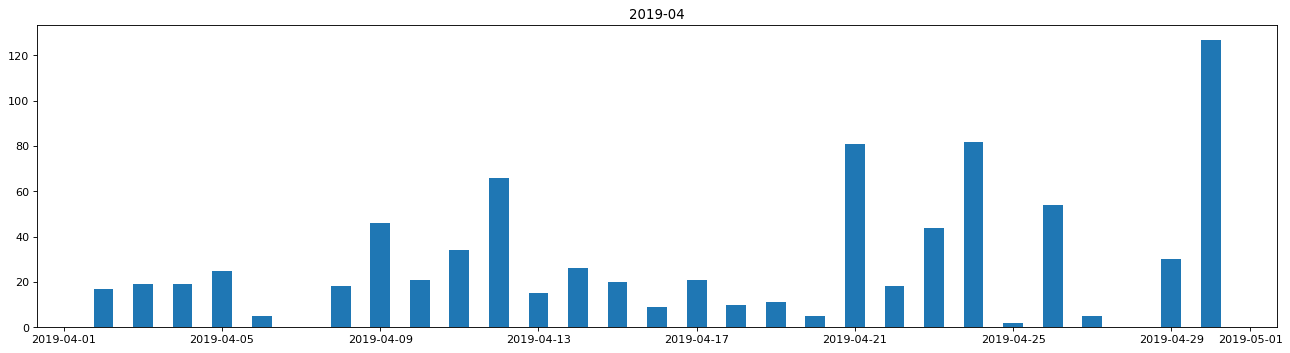

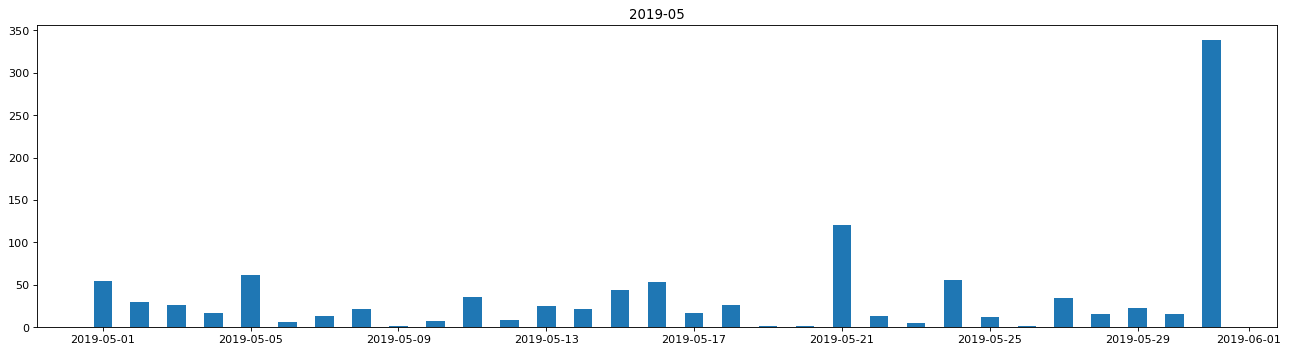

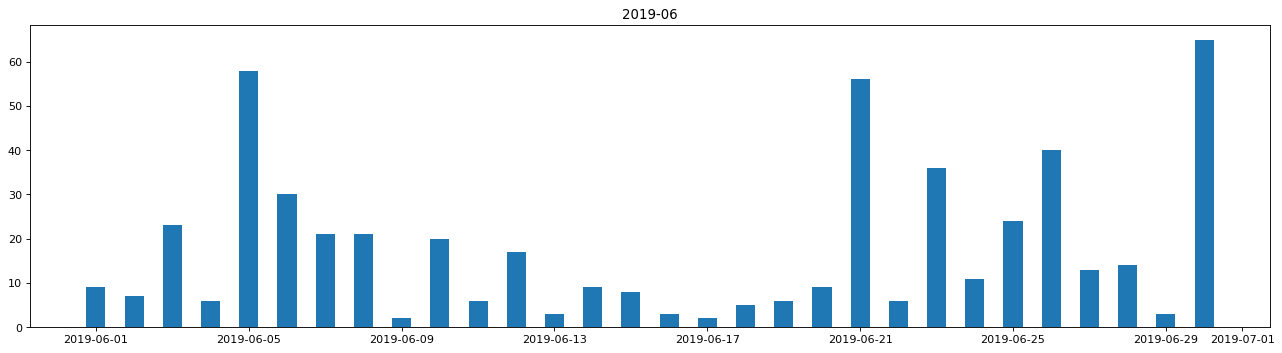

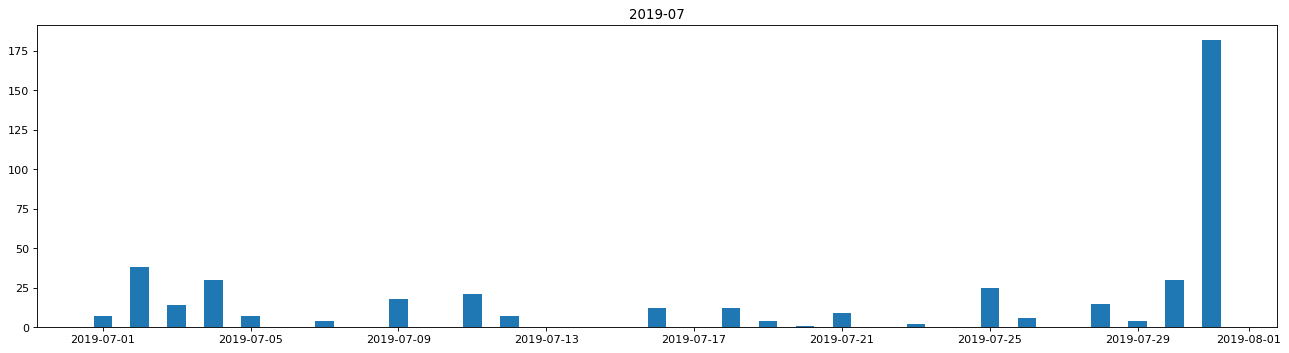

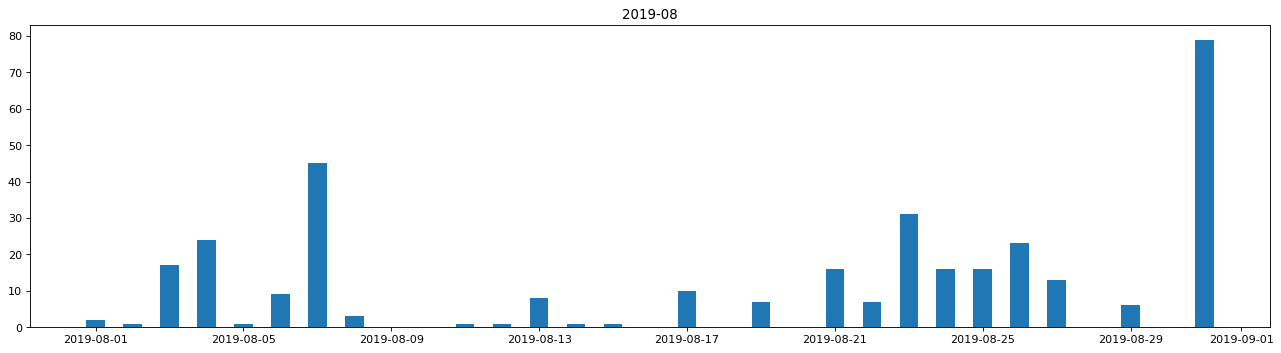

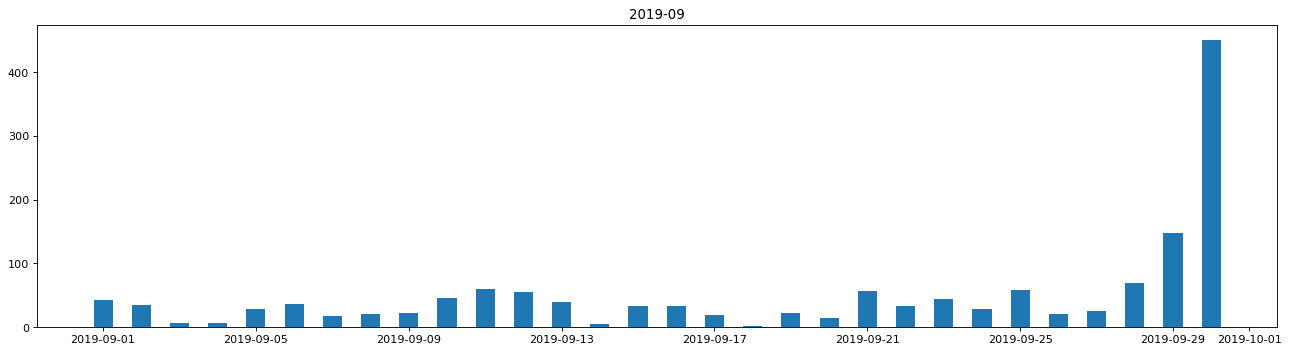

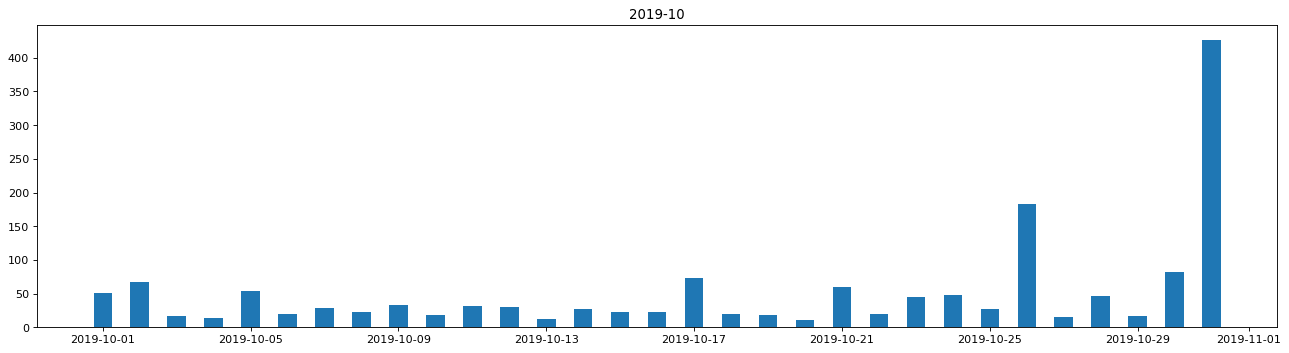

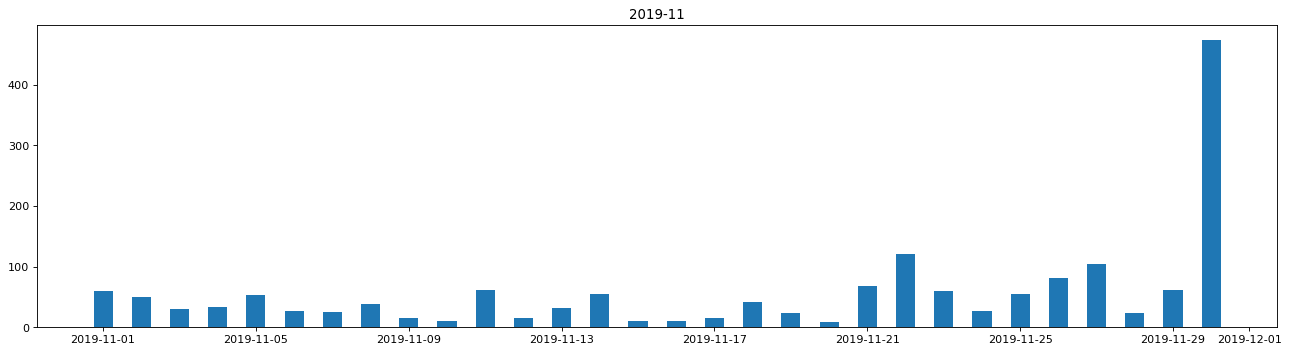

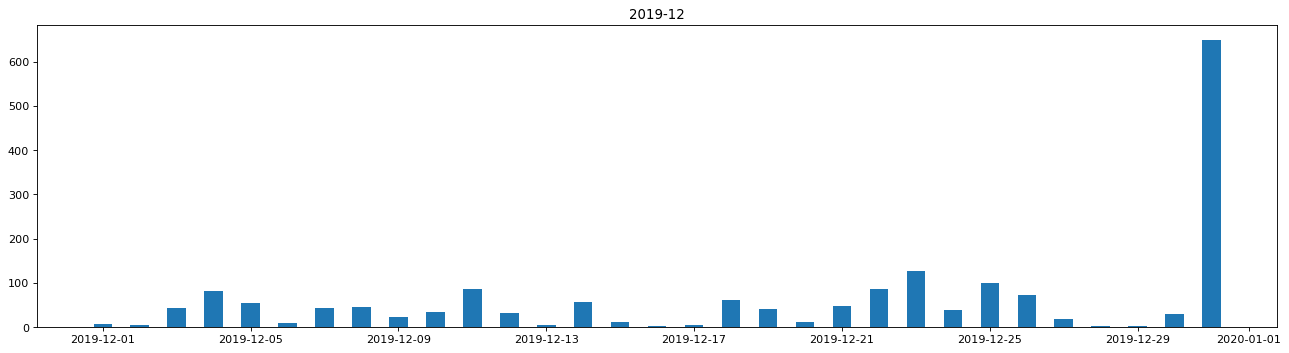

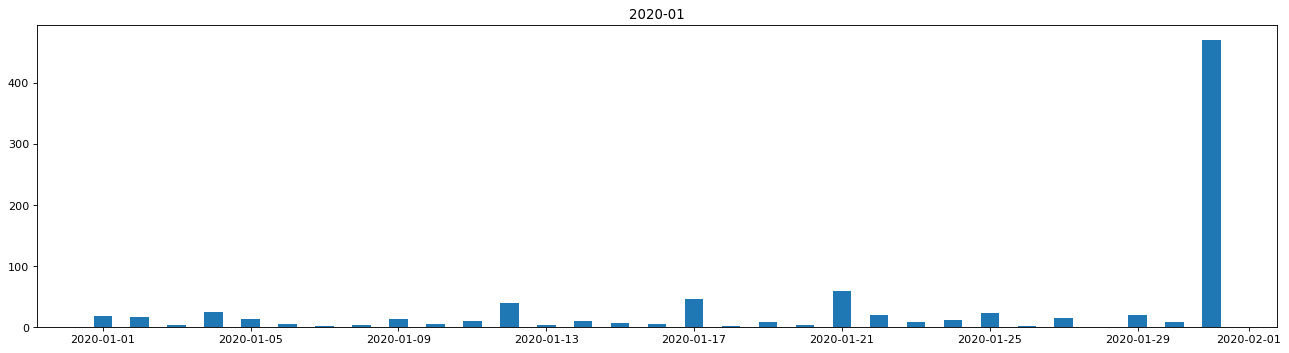

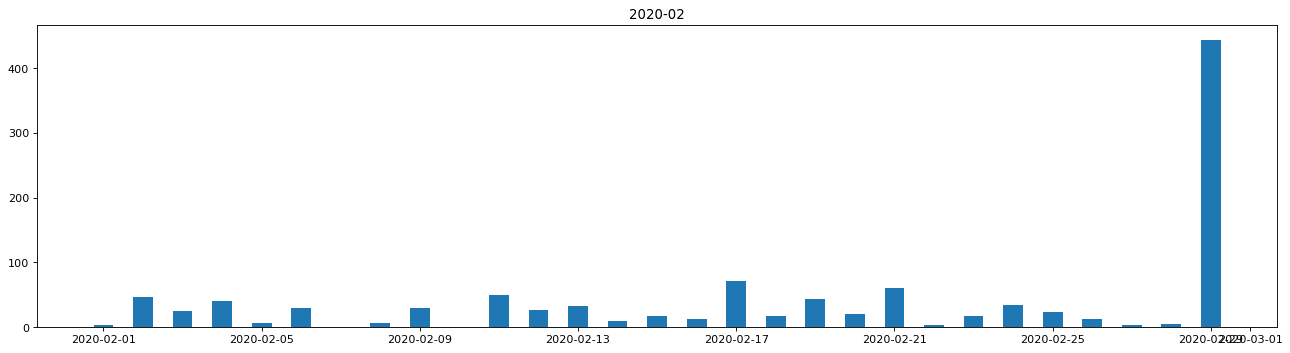

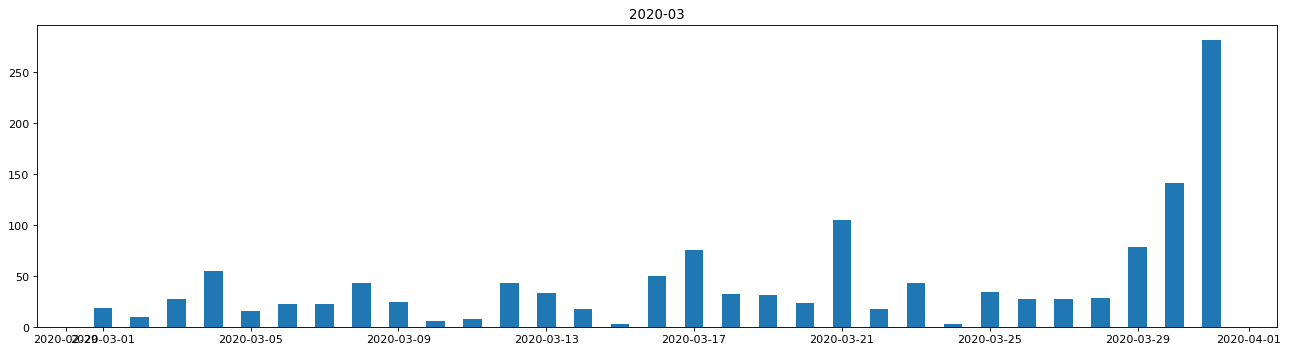

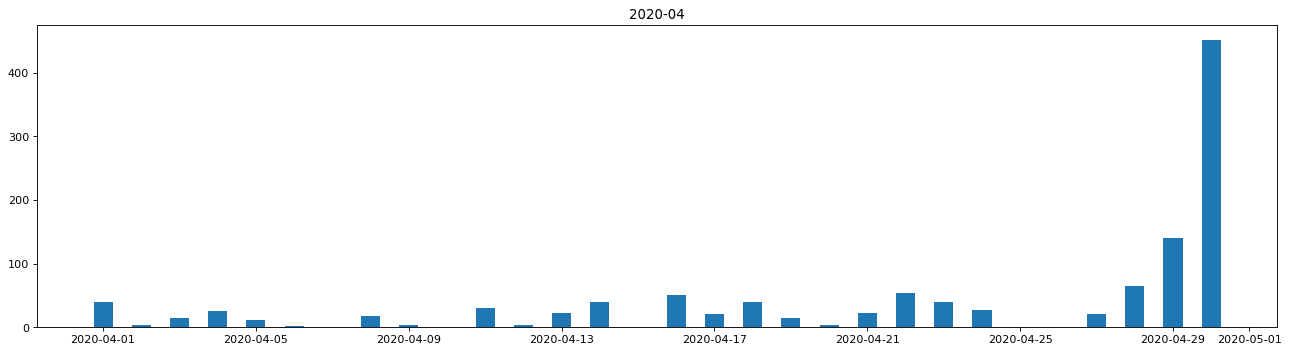

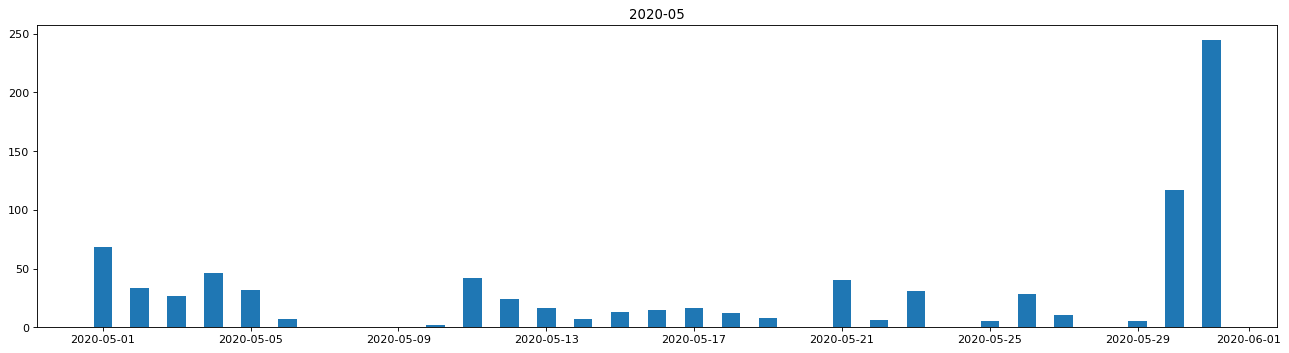

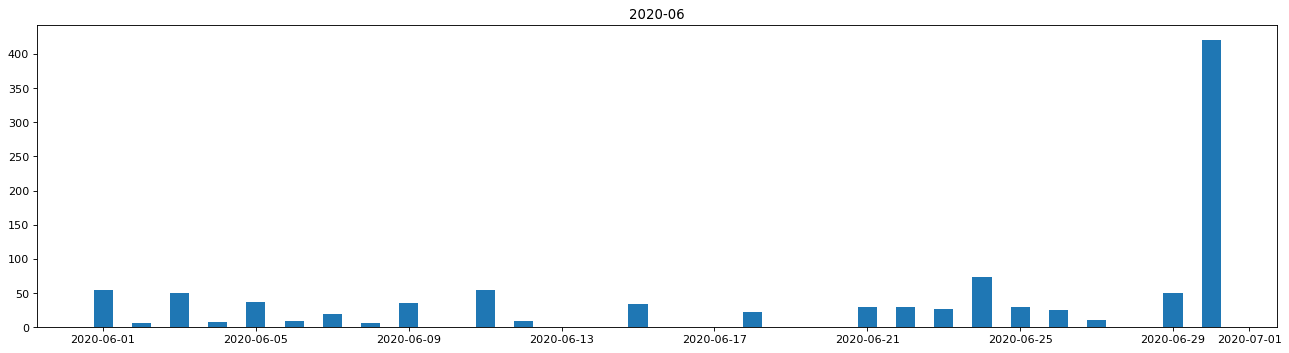

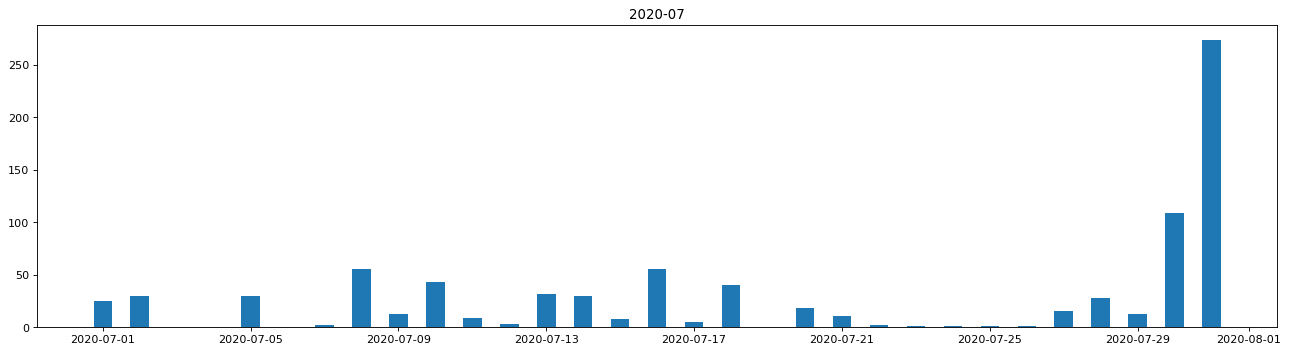

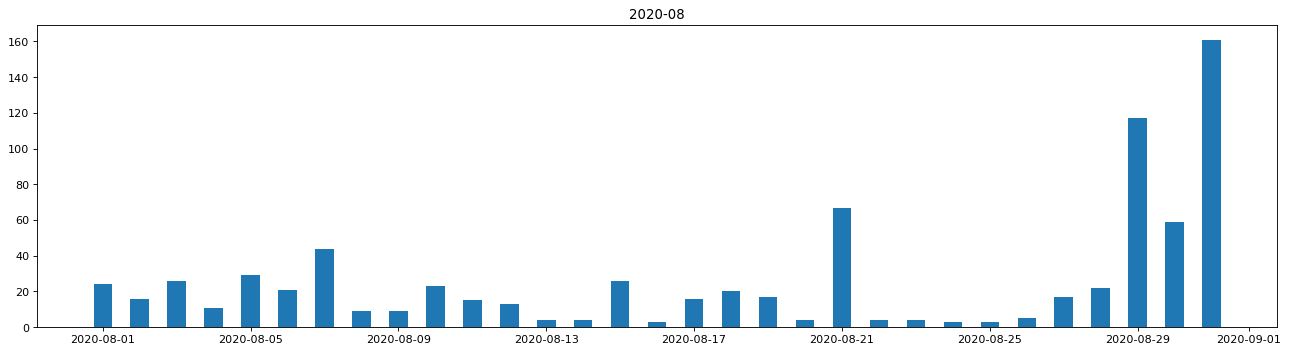

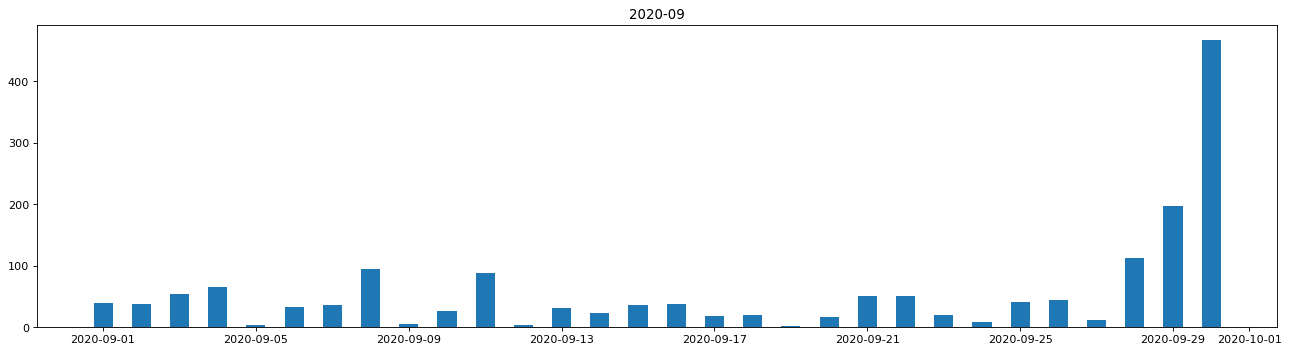

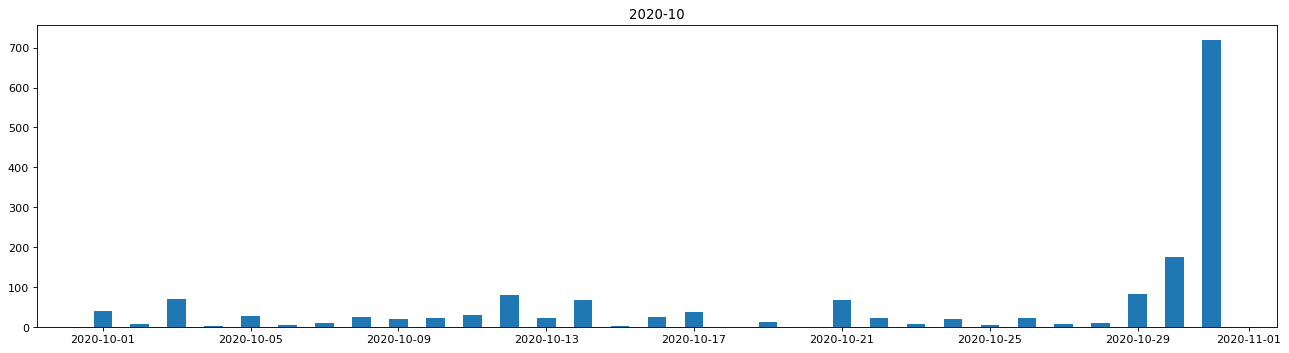

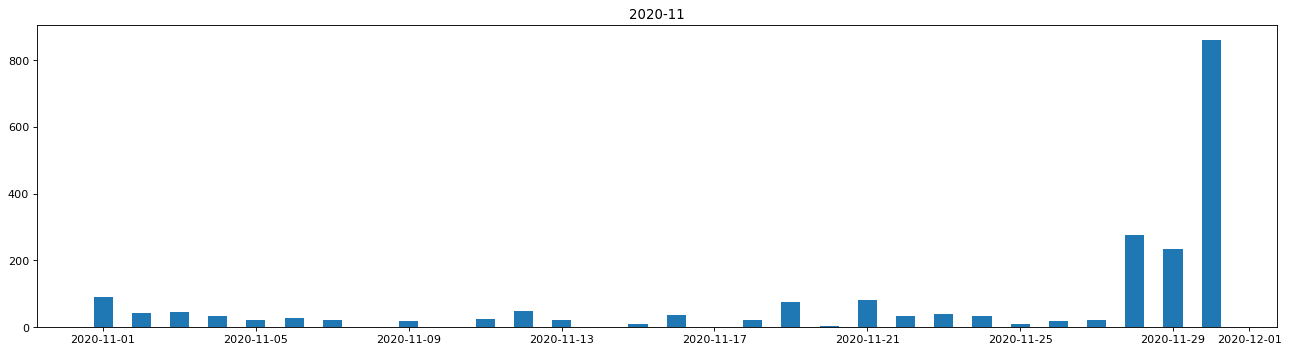

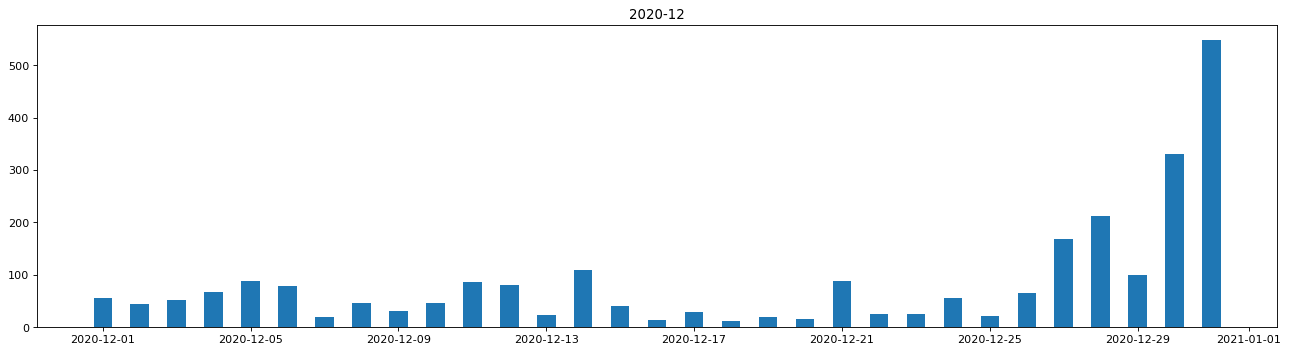

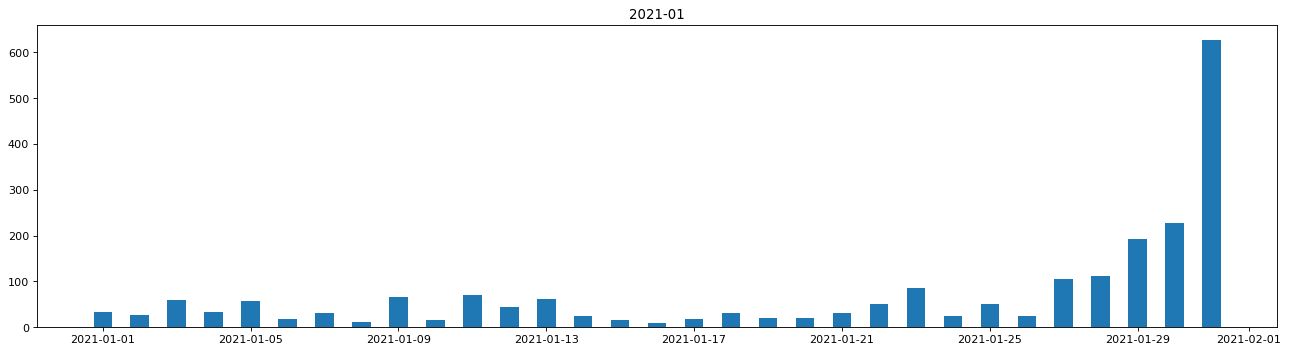

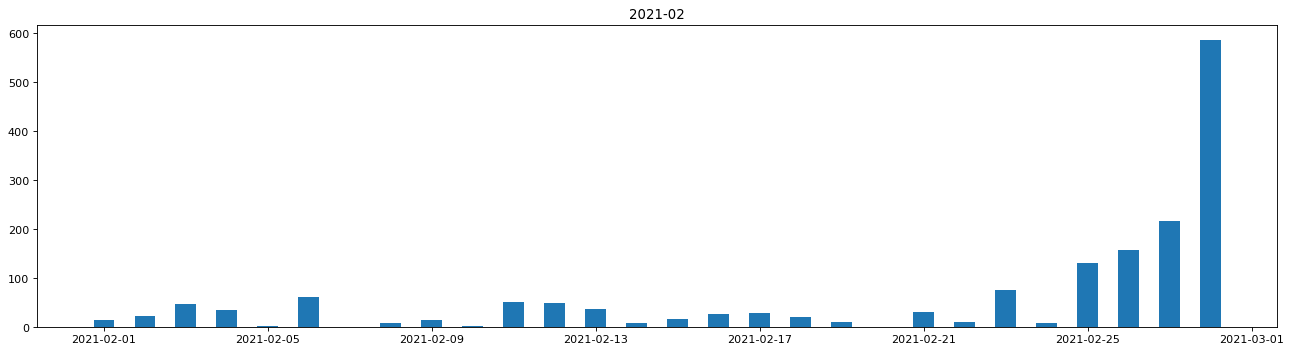

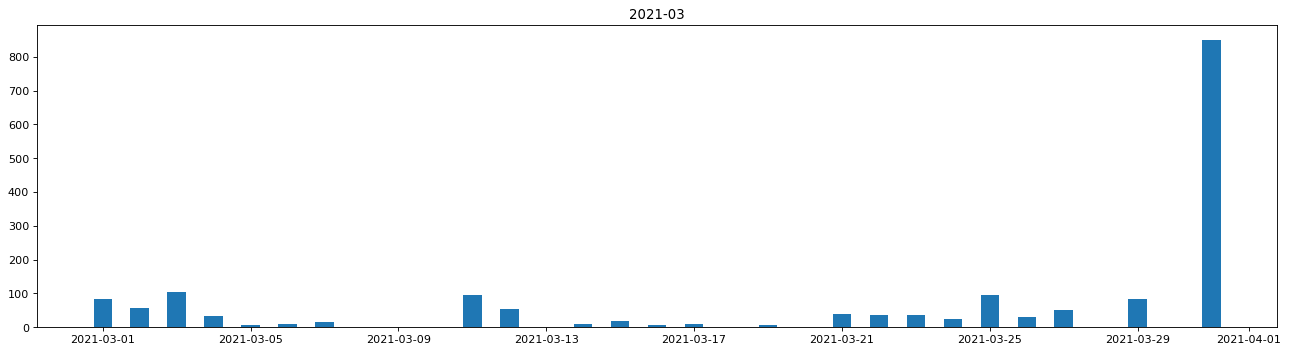

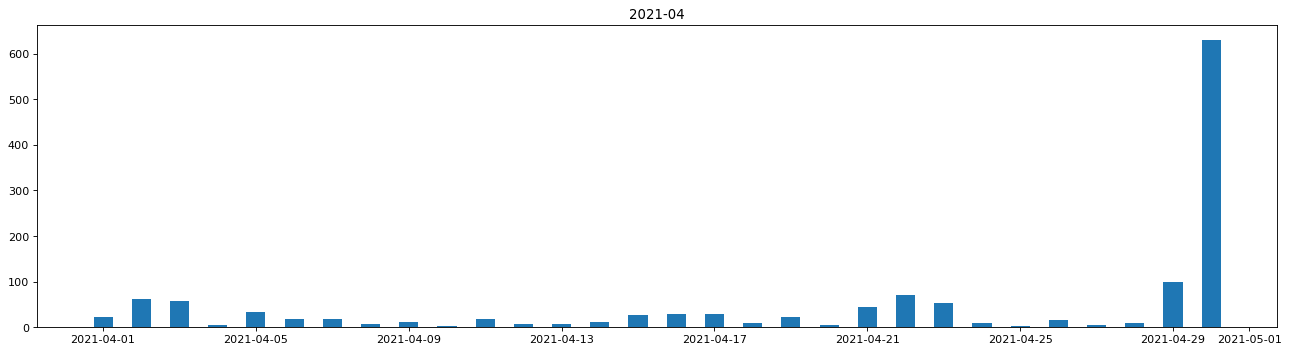

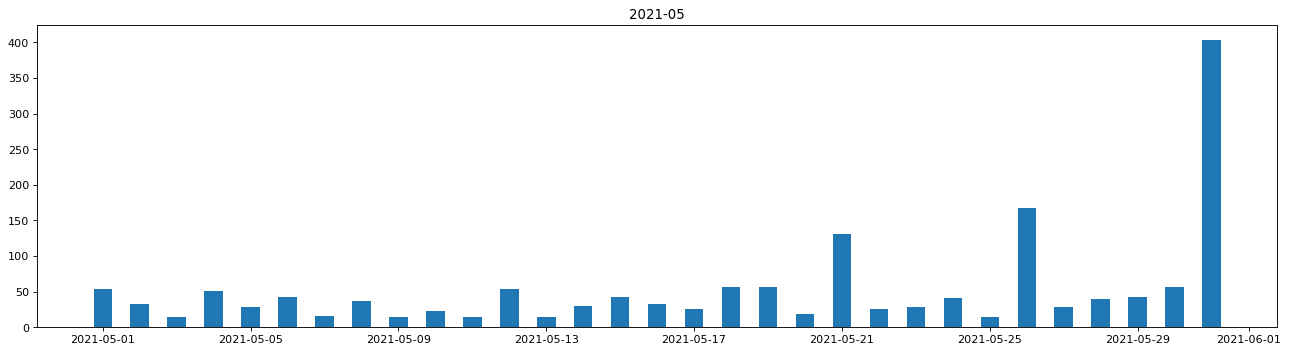

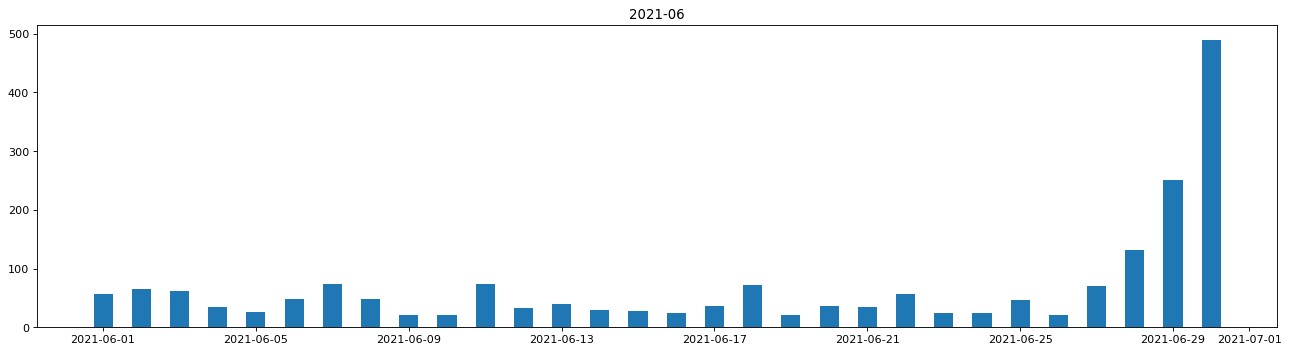

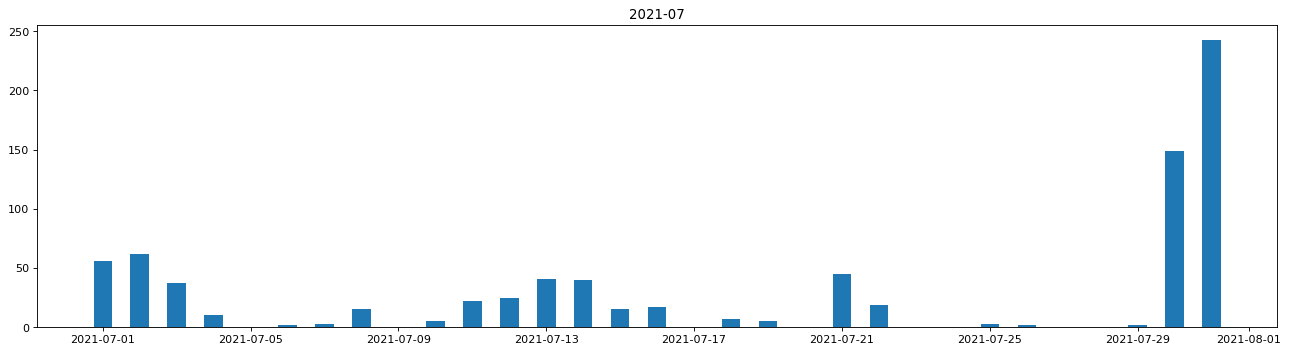

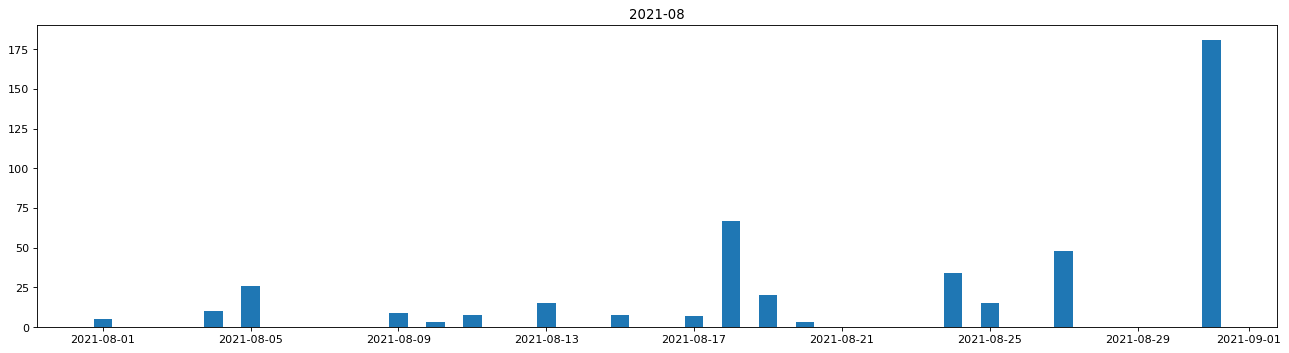

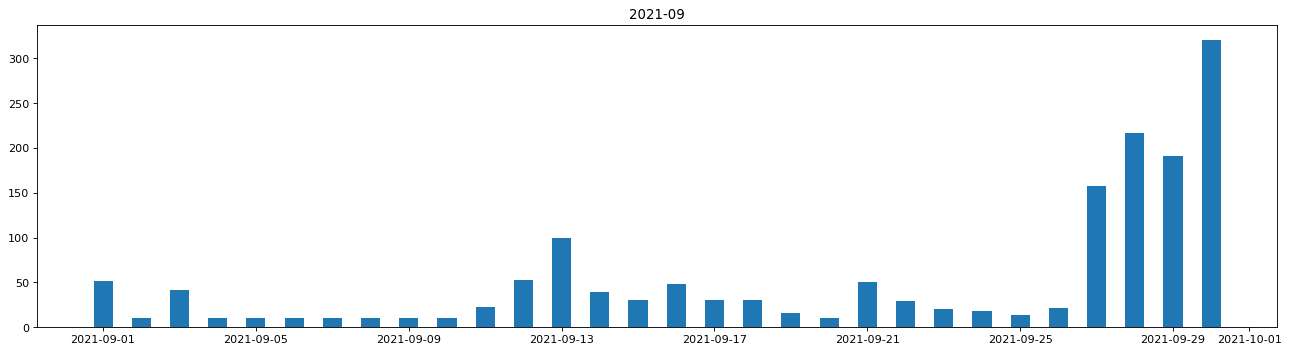

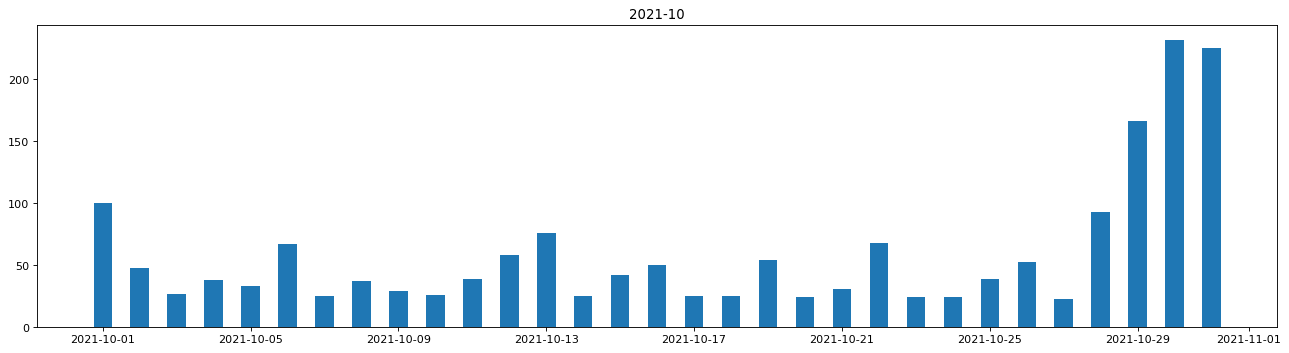

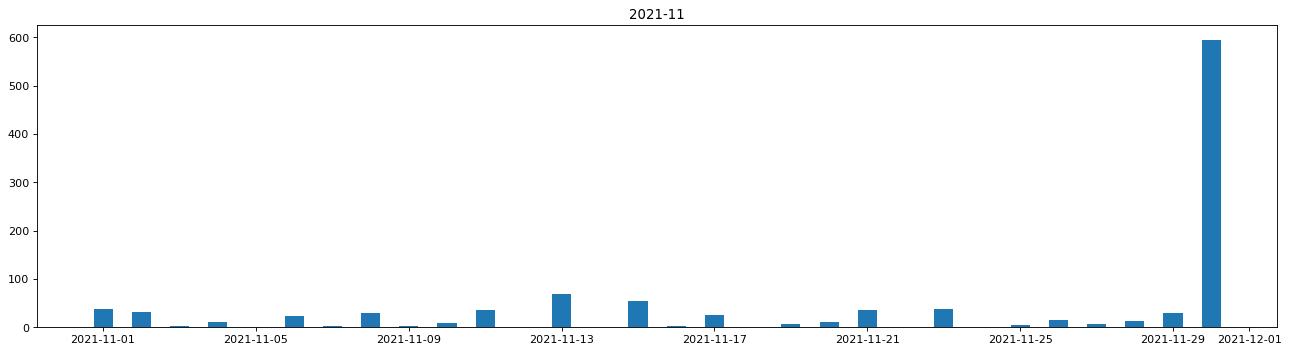

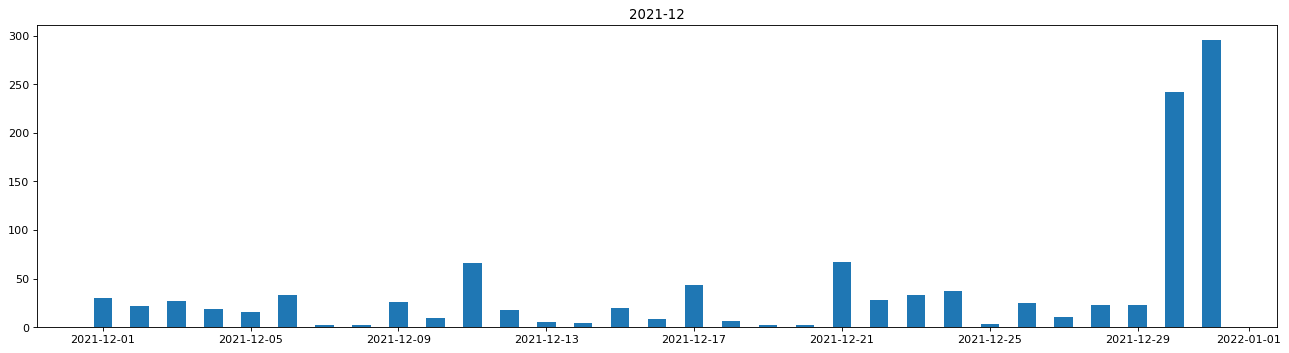

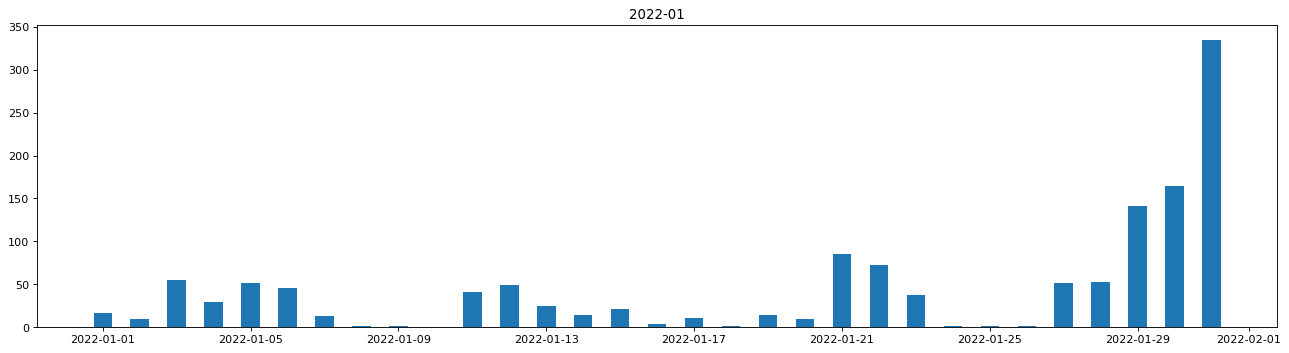

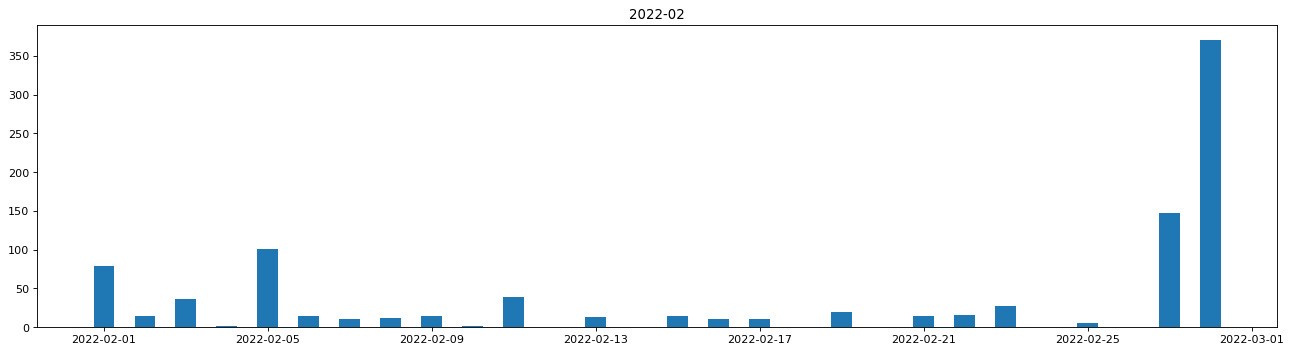

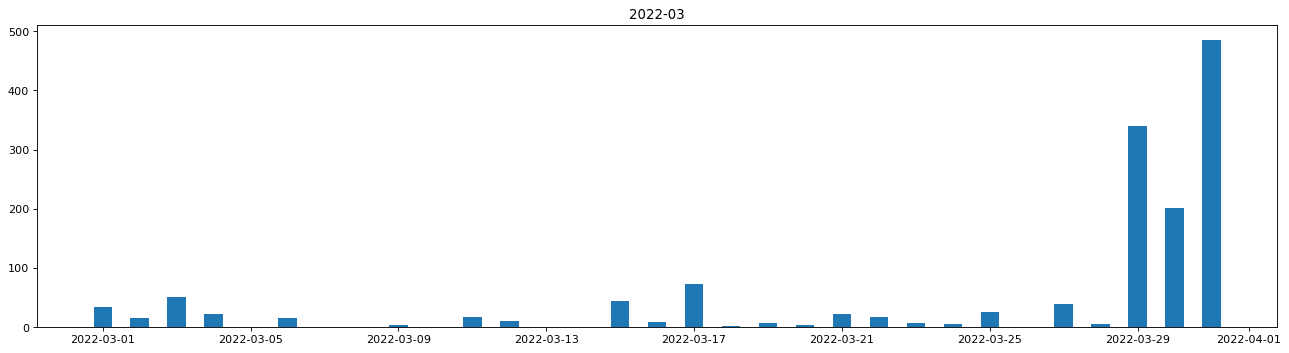

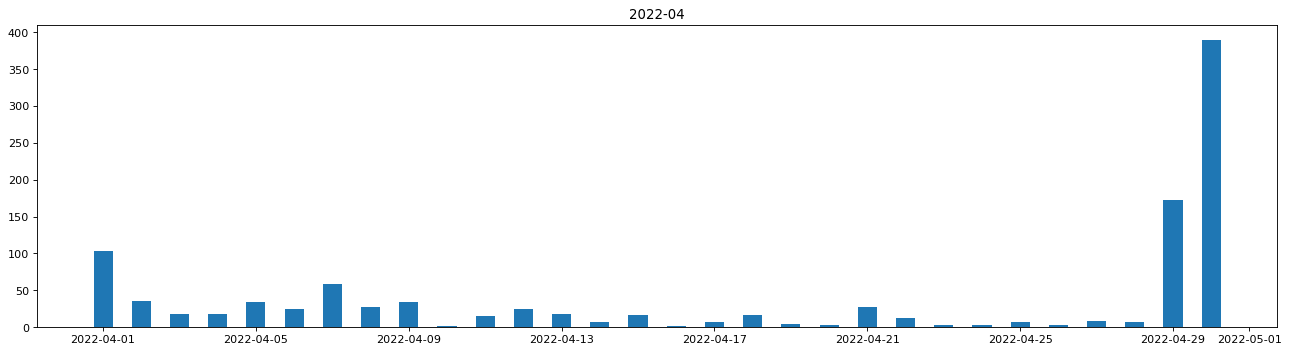

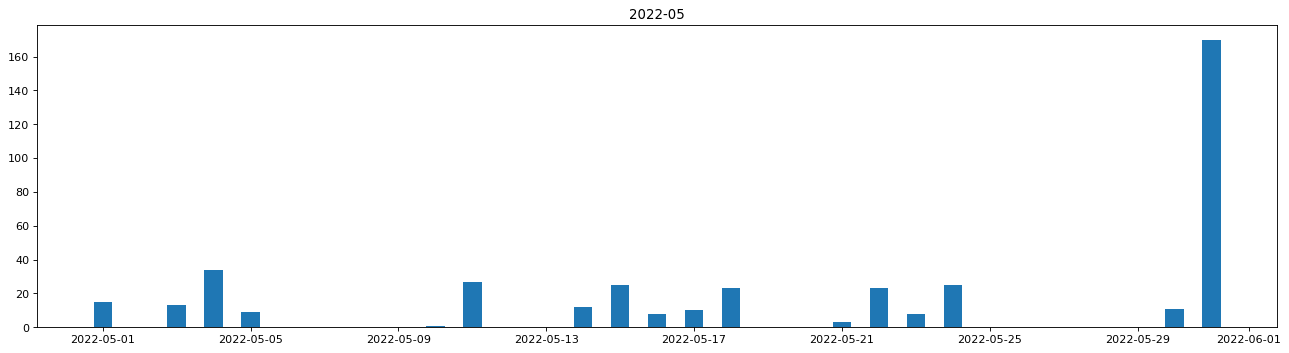

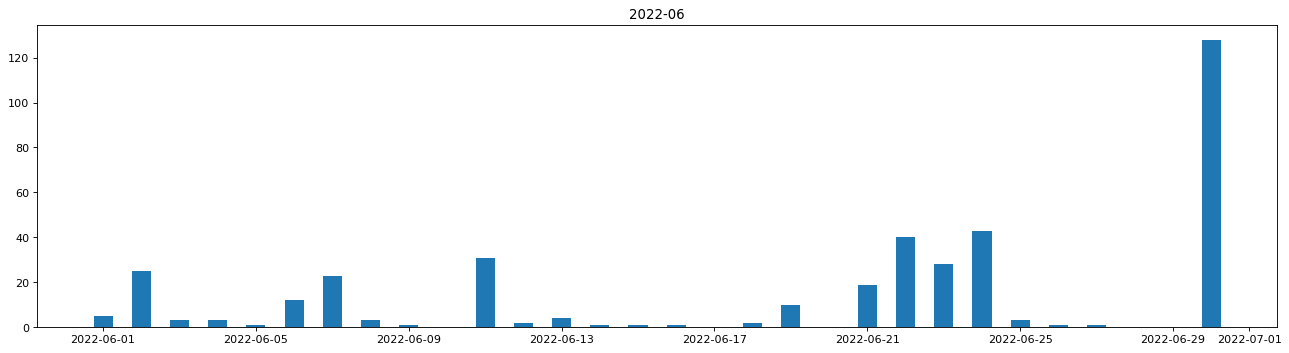

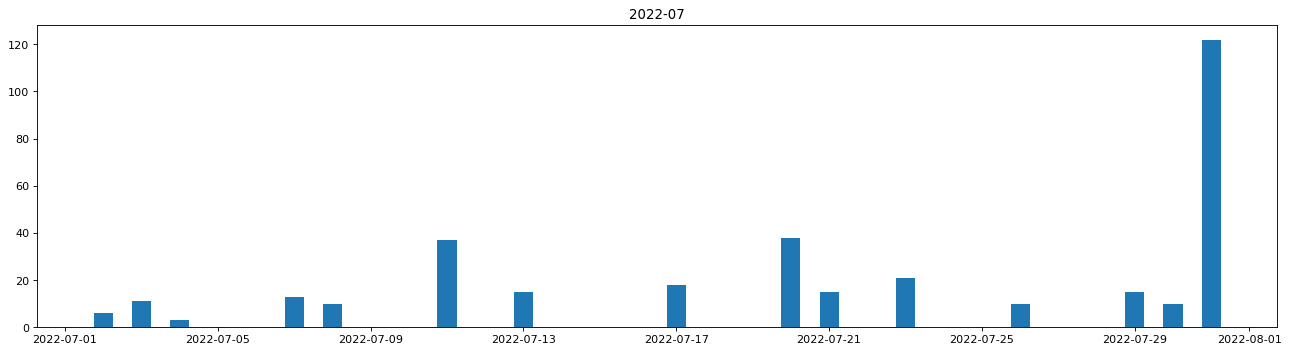

In [14]:
for i in lst:
    visualization_of_days(i)

#### По графикам можно увидеть что в последний день месяца большое количество отправок из станции. Видимо, пытаются добить отчет за месяц

#### В будущих прогнозах желательно не будем учитывать конечные дни месяцов, так как в них слишком большие выбросы

#### Построим baseline

In [15]:
X = pd.DataFrame(data.index)
X['month'] = pd.Series(data.index.month)
X['day'] = pd.Series(data.index.day)
X.drop({'Date'}, axis = 1, inplace=True)

In [16]:
y = data.quantity_of_wagons

def mine_train_test_split(X, y, train_size):
    X_train = X.iloc[:train_size]
    y_train = y.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_test = y.iloc[train_size:]
    return X_train, X_test, y_train, y_test

def model(data, X, y, train_size):
    train_size = int(len(data) * train_size)
    lr = Ridge()
    X_train, X_test, y_train, y_test = mine_train_test_split(X, y, train_size)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'RMSE = {np.sqrt(mean_squared_error(y_pred, y_test))}')
    print(f'MSE = {mean_squared_error(y_pred, y_test)}')
    print(f'MAE = {mean_absolute_error(y_pred, y_test)}')
    train = data[:train_size]
    valid = data[train_size:]
    valid['Predictions'] = y_pred
    plt.figure(figsize=(16, 8))
    plt.title("Model's result")
    plt.xlabel("Date")
    plt.ylabel("Quantity of Wagons")
    plt.plot(train['quantity_of_wagons'])
    plt.plot(valid[['quantity_of_wagons', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
    plt.show()
    del valid, train
    

RMSE = 68.84268127851115
MSE = 4739.31476561467
MAE = 44.56903881321425


C:\Users\F330~1\AppData\Local\Temp/ipykernel_10684/3953236175.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


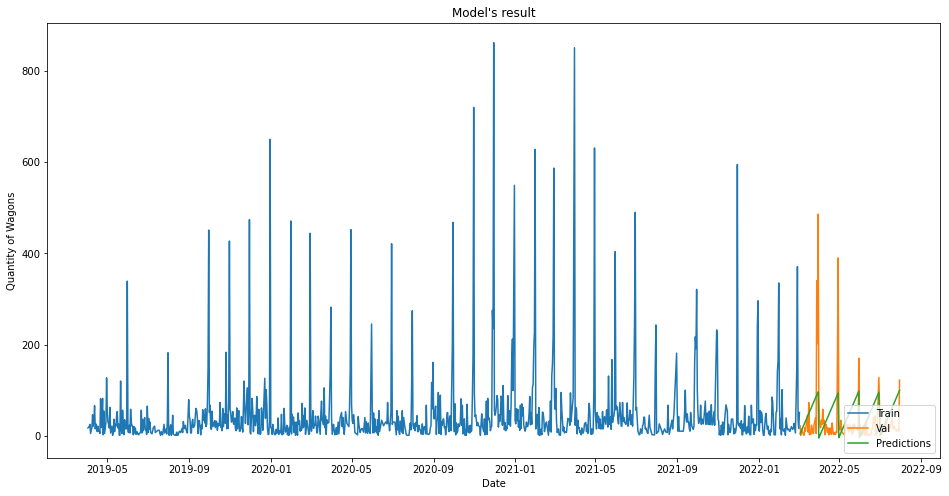

In [17]:
model(data, X, y, 0.9)

#### Отлично, попробуем превзойти этот baseline

#### Так как у нас временные ряды, будем добавлять фичи зависящие от времени. В данном случае добавим фичу конец месяца

In [18]:
def is_months_end(num):
    if num.is_month_end == True:
        return 1
    return 0


series = pd.Series(data.index).apply(is_months_end)
data['is_end_of_month'] = list(series)
data

,quantity_of_wagons,is_end_of_month
Date,,
2019-04-02,17,0
2019-04-03,19,0
2019-04-04,19,0
2019-04-05,25,0
2019-04-06,5,0
...,...,...
2022-07-23,21,0
2022-07-26,10,0
2022-07-29,15,0


#### Посмотрим графики кварталов каждого года

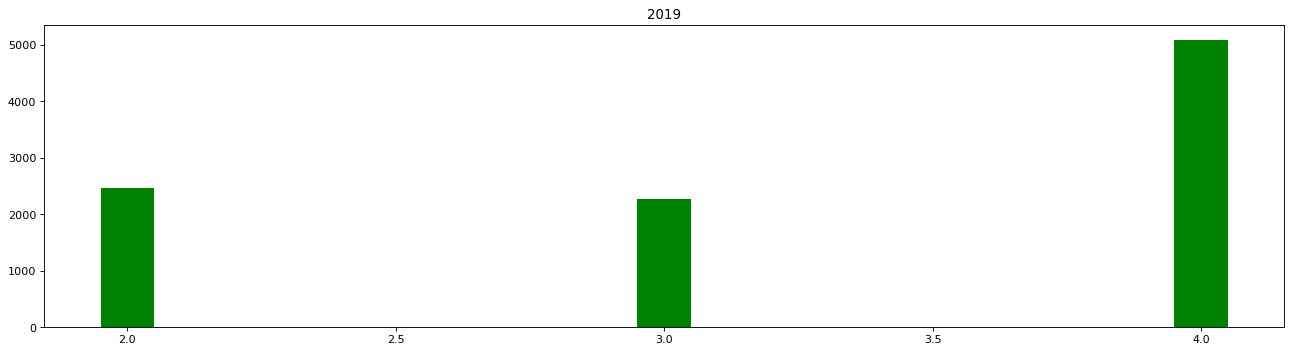

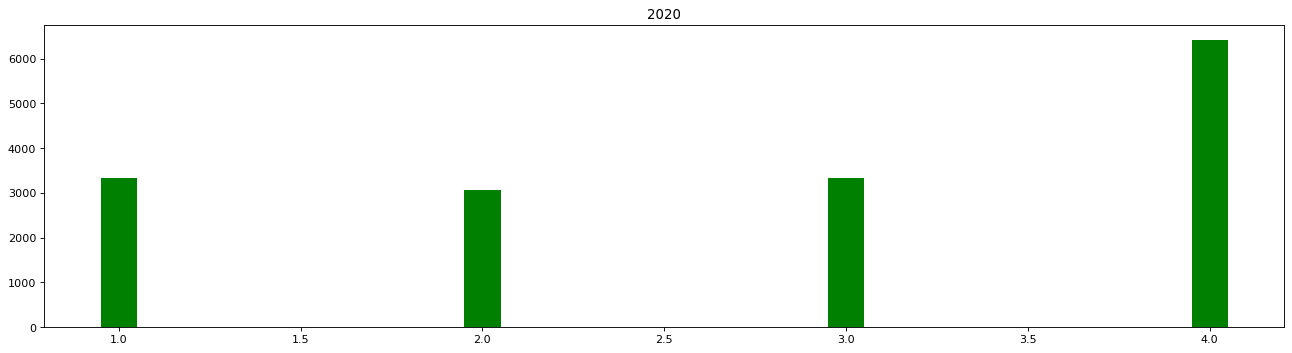

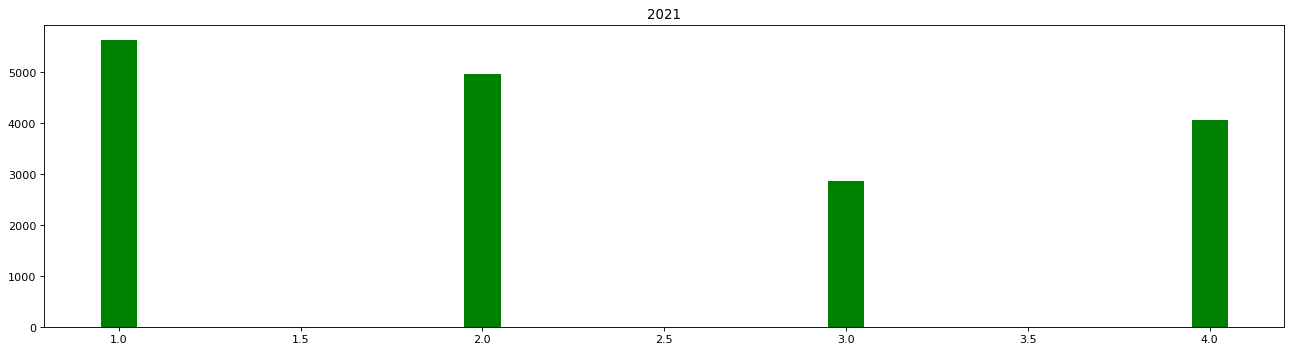

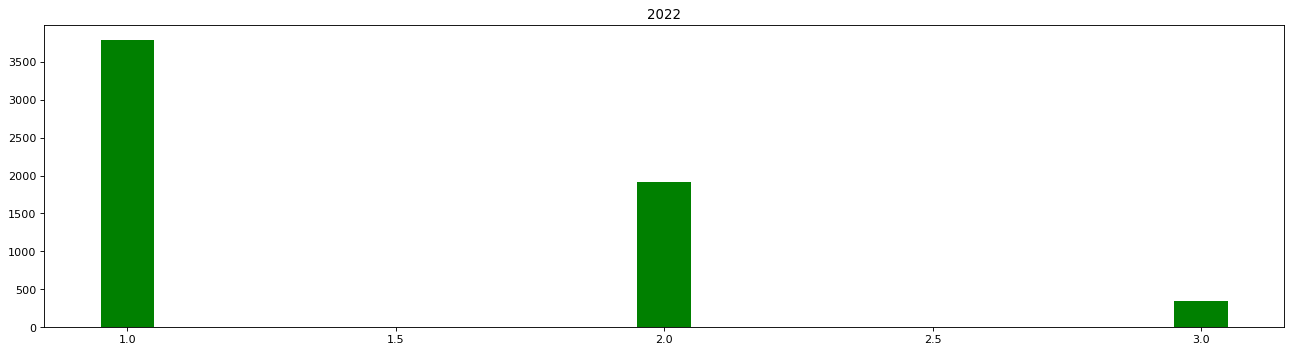

In [19]:
data['quarter'] = list(pd.Series(data.index.values).dt.quarter)
def visualization_of_quarters(str):
    figure(figsize=(20, 5), dpi=80)
    plt.bar(data.loc[str+'-01':str+'-12'].groupby('quarter')['quantity_of_wagons'].sum().index.values, \
            data.loc[str+'-01':str+'-12'].groupby('quarter')['quantity_of_wagons'].sum().values, width = 0.1, color="g")
    plt.title(str)
lst = ['2019', '2020', '2021', '2022']
for i in lst:
    visualization_of_quarters(i)

#### Здесь можно заметить, что самое малое количество отправок идет на лето, так как видимо летом нет урожая зерна

#### Построим функцию частичной автокорреляции, который выевляет нам зависимости текущих дней от предыдущих. По оси x у нас лаги(сколько-то дней назад), по оси y корреляция. Синяя рамка - доверительный интервал

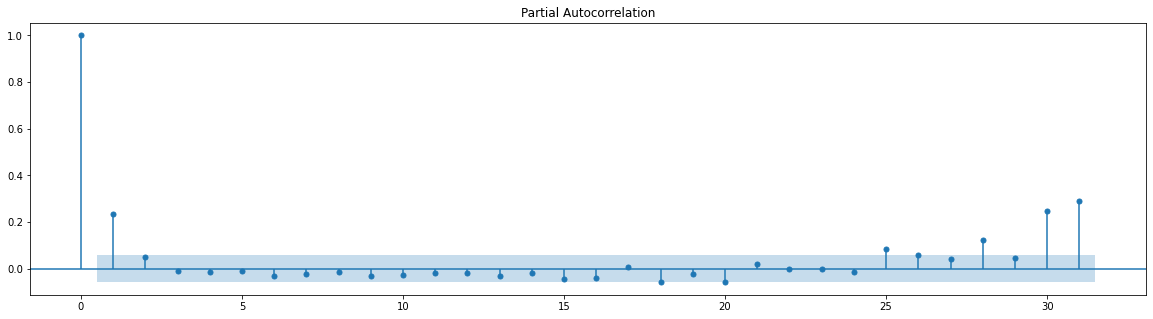

In [20]:
matplotlib.rcParams['figure.figsize'] = [20, 5]
plot_pacf(data[['quantity_of_wagons']], lags=31)
plt.show()

#### Смотря на график, можно преположить, что есть небольшая зависимость от предыдущего дня 

In [21]:
data['month'] = list(pd.Series(data.index.month))
data['year'] = list(pd.Series(data.index.year))

In [22]:
data

,quantity_of_wagons,is_end_of_month,quarter,month,year
Date,,,,,
2019-04-02,17,0,2,4,2019
2019-04-03,19,0,2,4,2019
2019-04-04,19,0,2,4,2019
2019-04-05,25,0,2,4,2019
2019-04-06,5,0,2,4,2019
...,...,...,...,...,...
2022-07-23,21,0,3,7,2022
2022-07-26,10,0,3,7,2022
2022-07-29,15,0,3,7,2022


In [23]:
data[data.is_end_of_month == 0].loc['2019-05':'2019-05']

,quantity_of_wagons,is_end_of_month,quarter,month,year
Date,,,,,
2019-05-01,55,0,2,5,2019
2019-05-02,30,0,2,5,2019
2019-05-03,26,0,2,5,2019
2019-05-04,17,0,2,5,2019
2019-05-05,62,0,2,5,2019
2019-05-06,6,0,2,5,2019
2019-05-07,13,0,2,5,2019
2019-05-08,21,0,2,5,2019
2019-05-09,1,0,2,5,2019


#### Построим график показывающий количетсво отправок за месяцы каждого года

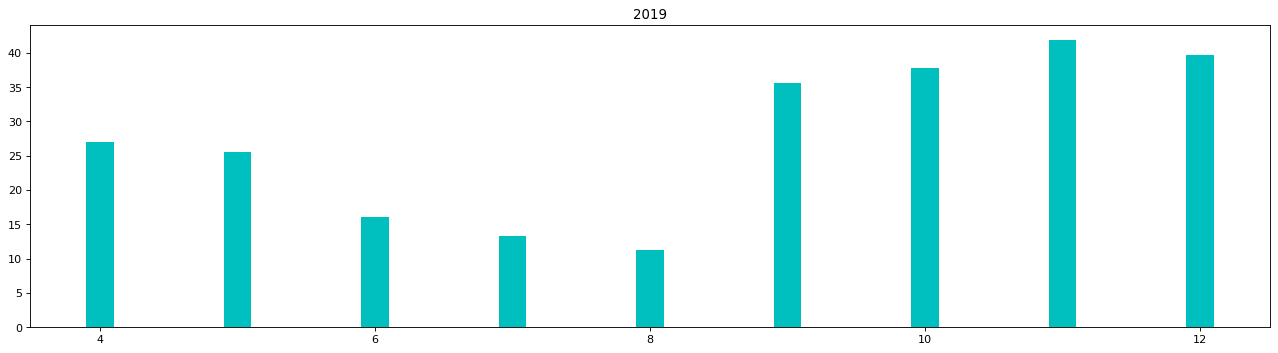

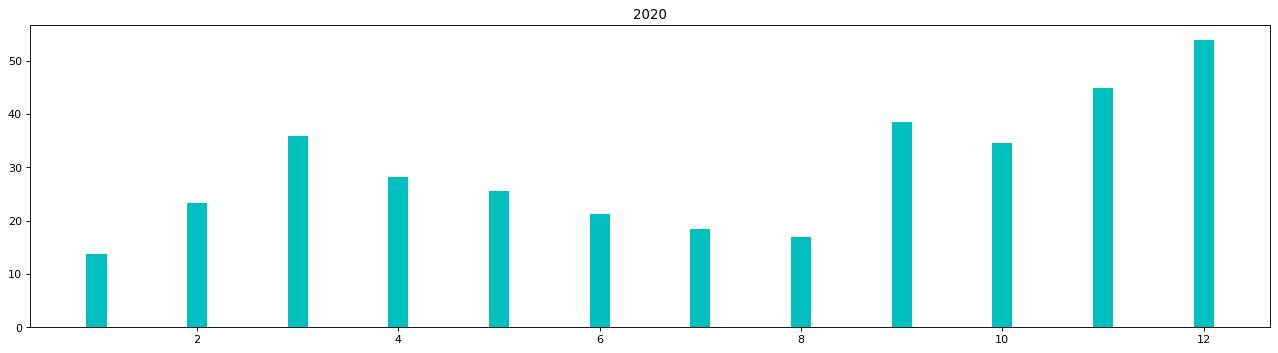

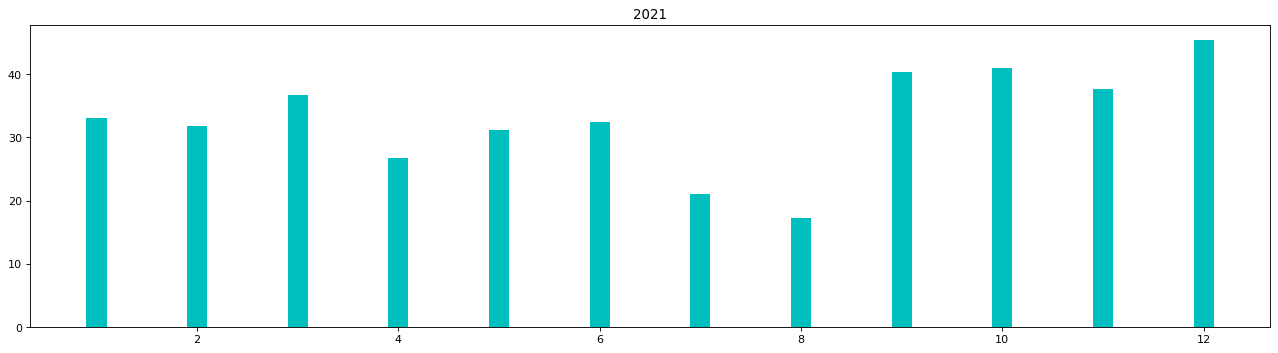

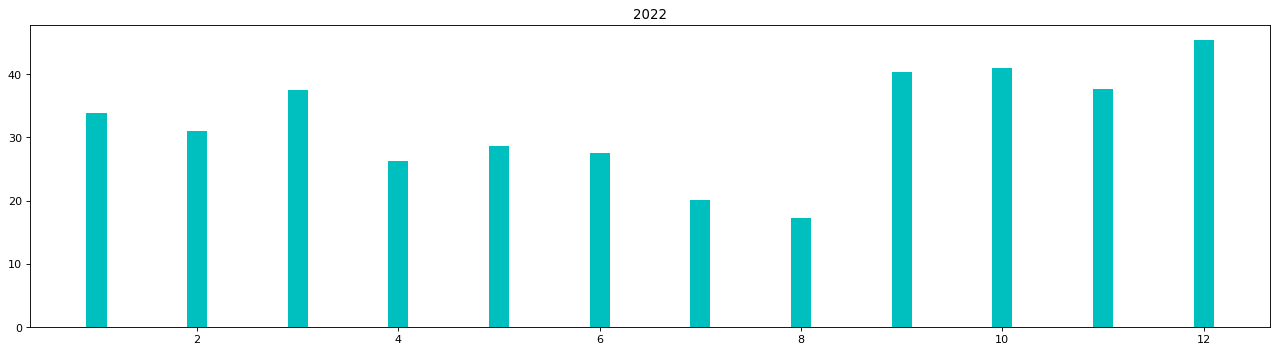

In [24]:
def mean_of_month_in_each_year(str):
    figure(figsize=(20, 5), dpi=80)
    plt.bar(data[data.is_end_of_month == 0].loc[:str].groupby(['month']).quantity_of_wagons.mean().index.values, \
            data[data.is_end_of_month == 0].loc[:str].groupby(['month']).quantity_of_wagons.mean().values, width = 0.2, color="c")
    plt.title(str)

    
lst = ['2019', '2020', '2021', '2022']

for i in lst:
    mean_of_month_in_each_year(i)

#### С декабрем что-то не так. Очень много отправок. Может потому что это конец года?

#### Учитывая все это, думаю можно добавить сезонность или же месяцы

#### Протестируем с фичами, которые нам удалось пока выделить

In [25]:
data[['1_quarter', '2_quarter', '3_quarter', '4_quarter']] = pd.get_dummies(data.quarter)

RMSE = 52.765968084257295
MSE = 2784.2473878688597
MAE = 32.48383718763912


C:\Users\F330~1\AppData\Local\Temp/ipykernel_10684/3953236175.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


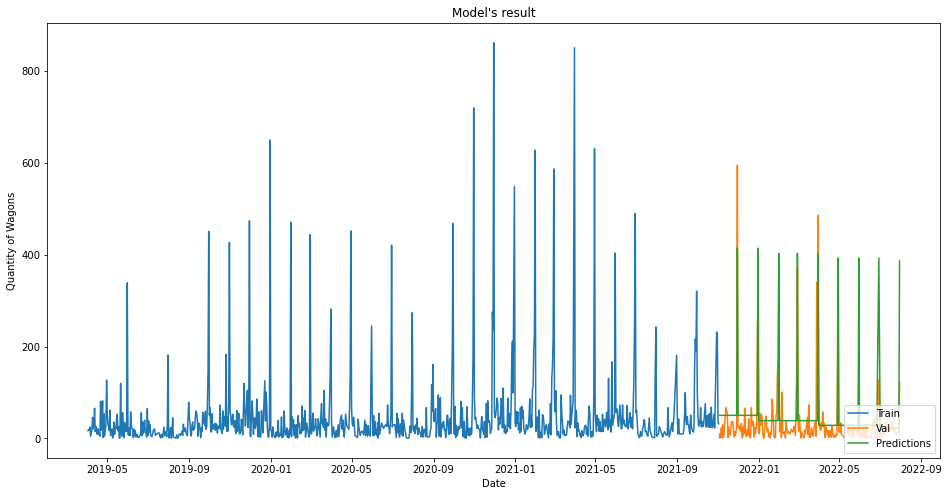

In [26]:
X = data[['is_end_of_month', '1_quarter', '2_quarter', '3_quarter', '4_quarter']]
y = data['quantity_of_wagons']
model(data, X, y, 0.8)

#### Чувствуется улучшение, чем с прошлого раза. В прошлый раз метрика в baseline была равна 72, а сейчас она равна 52

#### Рассмотрим теперь дни недели

In [27]:
data['weekday'] = list(data.index.weekday)

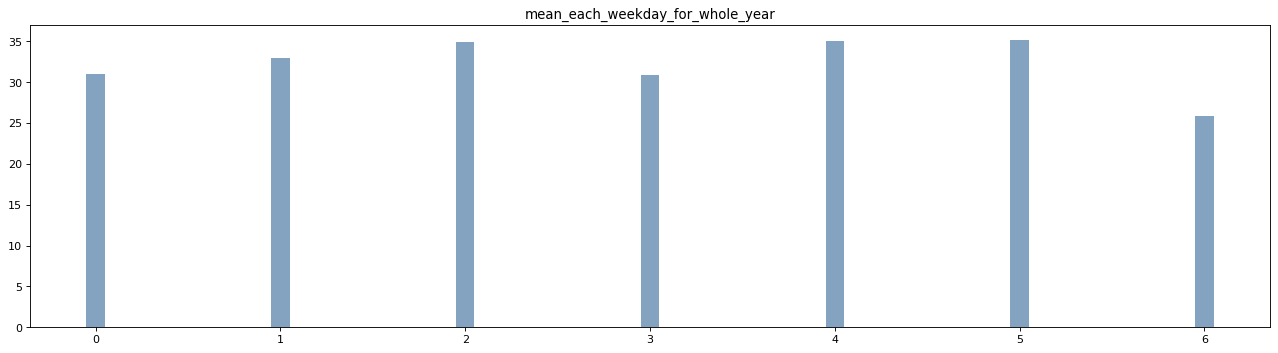

In [28]:
# Рассмотрим среднее по неделям за весь датасет
def visualization_of_weeks_mean_whole_dataset():
    figure(figsize=(20, 5), dpi=80)
    plt.bar(data[data.is_end_of_month == 0].groupby(['weekday'])['quantity_of_wagons'].mean().index.values, \
            data[data.is_end_of_month == 0].groupby(['weekday'])['quantity_of_wagons'].mean().values, width = 0.1, color=(0.2, 0.4, 0.6, 0.6))
    plt.title('mean_each_weekday_for_whole_year')
    
visualization_of_weeks_mean_whole_dataset()

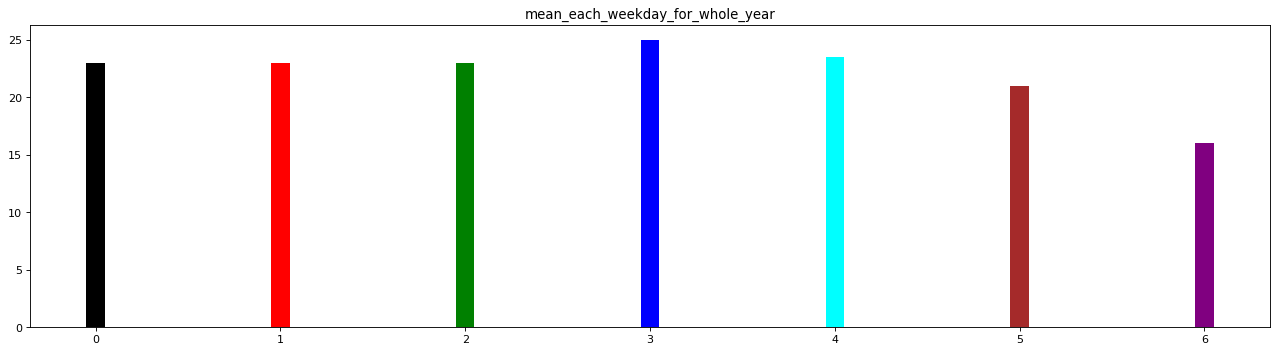

In [29]:
# Рассмотрим медиану за весь датасет
def visualization_of_weeks_median_whole_dataset():
    figure(figsize=(20, 5), dpi=80)
    plt.bar(data[data.is_end_of_month == 0].groupby(['weekday'])['quantity_of_wagons'].median().index.values, \
            data[data.is_end_of_month == 0].groupby(['weekday'])['quantity_of_wagons'].median().values, width = 0.1, color=['black', 'red', 'green', 'blue', 'cyan', 'brown', 'purple'])
    plt.title('median_each_weekday_for_whole_year')
    
visualization_of_weeks_median_whole_dataset()

#### Думаю все-таки стоит добавить фичи дней недель

In [30]:
data[['monday', 'tuesday', 'wednesday', 'thusday', 'friday', 'saturday', 'sunday']] = pd.get_dummies(data.weekday)

#### Также добавим данные за прошлый день - небольшую зависимость которой мы вывели с помощью частичной автокорреляции 

In [31]:
data['previous'] = data['quantity_of_wagons'].shift(1)

RMSE = 51.60869734594902
MSE = 2663.457641745765
MAE = 31.025979838417854


C:\Users\F330~1\AppData\Local\Temp/ipykernel_10684/3953236175.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


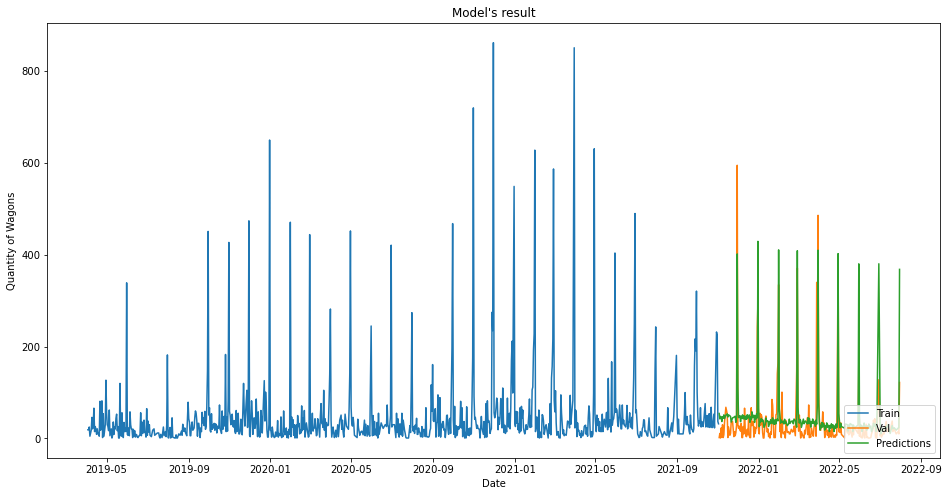

In [32]:
X = data.drop(['2019-04-02'], axis = 0)[['is_end_of_month', 'monday', 'tuesday', \
                                         'wednesday', 'thusday', 'friday', 'saturday', \
                                         'sunday', '1_quarter', '2_quarter', '3_quarter', \
                                         '4_quarter', 'previous']]

y = data.drop(['2019-04-02'], axis = 0)['quantity_of_wagons']
model(data.drop(['2019-04-02'], axis = 0), X, y, train_size=0.8)

#### Теперь попробуем убрать previous значения

RMSE = 52.84629788510974
MSE = 2792.7312001617543
MAE = 32.46158208468019


C:\Users\F330~1\AppData\Local\Temp/ipykernel_10684/3953236175.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


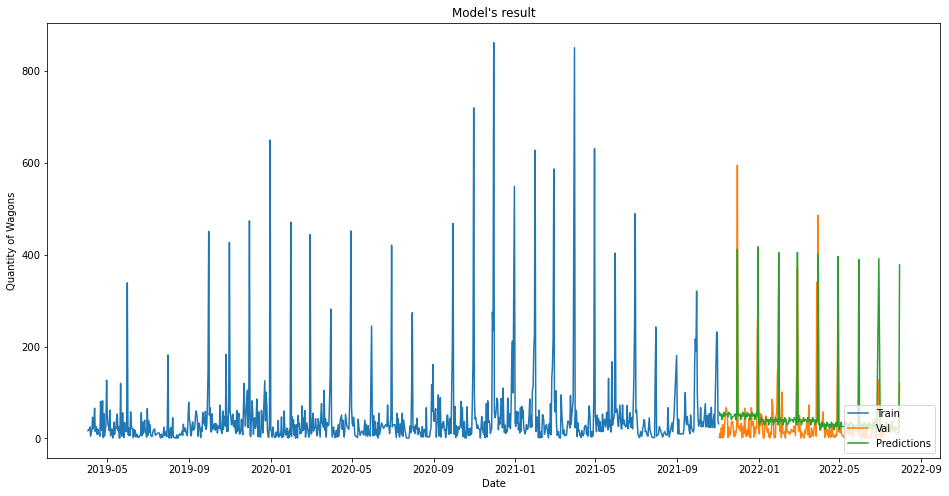

In [33]:
X = data[['is_end_of_month', 'monday', 'tuesday', \
                                         'wednesday', 'thusday', 'friday', 'saturday', \
                                         'sunday', '1_quarter', '2_quarter', '3_quarter', \
                                         '4_quarter']]

y = data['quantity_of_wagons']
model(data, X, y, train_size=0.8)

#### Видно, что лучше с фичей previous

In [34]:
data[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']] = pd.get_dummies(data.month)

RMSE = 52.168968551887716
MSE = 2721.6012797678495
MAE = 32.03993963831763


C:\Users\F330~1\AppData\Local\Temp/ipykernel_10684/3953236175.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


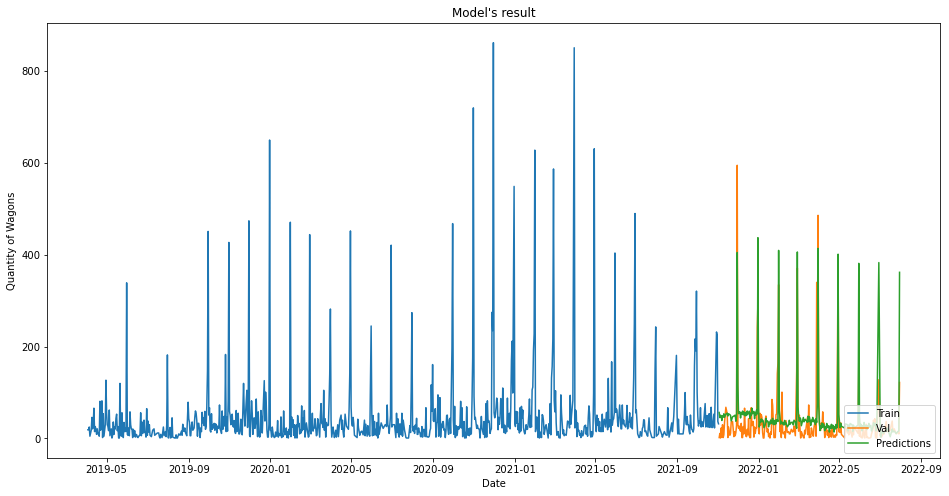

In [35]:
X = data.drop({'2019-04-02'}, axis = 0)[['is_end_of_month', 'monday', 'tuesday', 'wednesday', 'thusday',\
                                         'friday', 'saturday', 'sunday', 'jan', 'feb', 'mar', 'apr', 'may',\
                                         'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'previous']]

y = data.drop({'2019-04-02'}, axis = 0)['quantity_of_wagons']
model(data.drop({'2019-04-02'}, axis = 0), X, y, train_size=0.8)

#### Попробуем для фичи previous подставить разницу между целевой переменной и ее значением на вчерашний день

In [36]:
data['previous'] = data['quantity_of_wagons'] - data['previous']

In [37]:
data['previous']

Date
2019-04-02      NaN
2019-04-03      2.0
2019-04-04      0.0
2019-04-05      6.0
2019-04-06    -20.0
              ...  
2022-07-23      6.0
2022-07-26    -11.0
2022-07-29      5.0
2022-07-30     -5.0
2022-07-31    112.0
Name: previous, Length: 1093, dtype: float64

RMSE = 48.6958571221215
MSE = 2371.2865008580716
MAE = 33.187236920186045


C:\Users\F330~1\AppData\Local\Temp/ipykernel_10684/3953236175.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


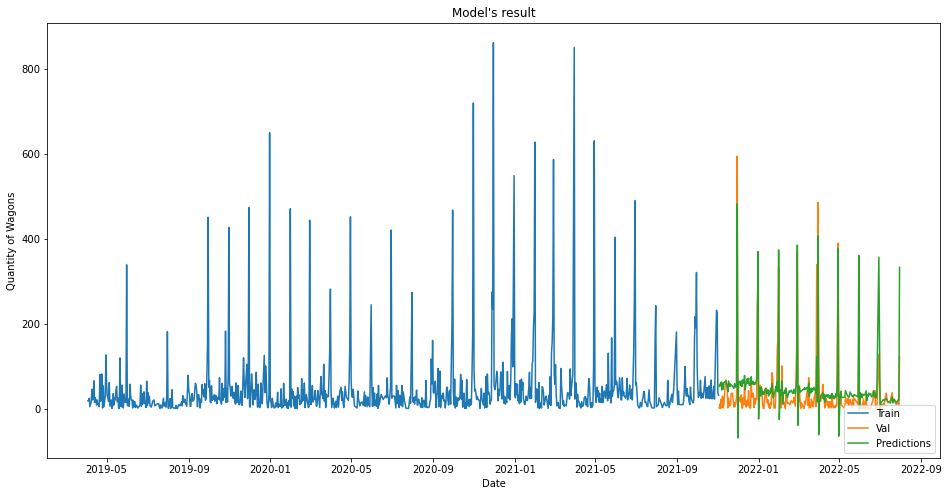

In [38]:
X = data.drop({'2019-04-02'}, axis = 0)[['is_end_of_month', 'monday', 'tuesday', 'wednesday', 'thusday',\
                                         'friday', 'saturday', 'sunday', 'jan', 'feb', 'mar', 'apr', 'may',\
                                         'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'previous']]

y = data.drop({'2019-04-02'}, axis = 0)['quantity_of_wagons']
model(data.drop({'2019-04-02'}, axis = 0), X, y, train_size=0.8)

#### Видно, что пошли к улучшению

#### Попробуем взять логарифм всего таргета

In [39]:
data['quantity_of_wagons'] = np.log2(data['quantity_of_wagons'])

RMSE = 1.9909928241756
MSE = 3.9640524259187324
MAE = 1.498312127285311


C:\Users\F330~1\AppData\Local\Temp/ipykernel_10684/3953236175.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_pred


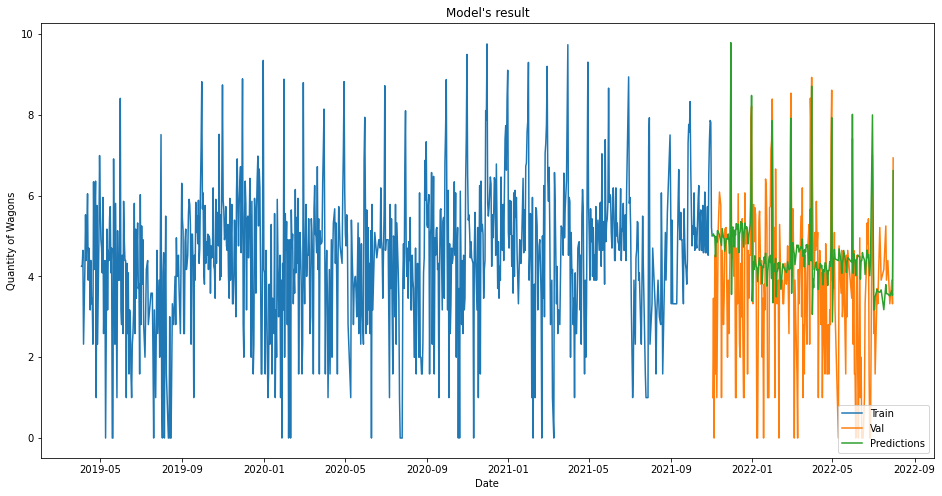

In [48]:
X = data.drop({'2019-04-02'}, axis = 0)[['is_end_of_month', 'monday', 'tuesday', 'wednesday', 'thusday',\
                                         'friday', 'saturday', 'sunday', 'jan', 'feb', 'mar', 'apr', 'may',\
                                         'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'previous']]

y = data.drop({'2019-04-02'}, axis = 0)['quantity_of_wagons']
model(data.drop({'2019-04-02'}, axis = 0), X, y, train_size=0.8)